# TinyGPT

**Autor: Abraham R.**

Este cuaderno es un ejemplo de un modelo GPT realmente pequeño llamado **TinyGPT**.
Repasarás la arquitectura GPT (transformer *decoder*) e implementarás las siguientes tareas:

## Arquitectura de TinyGPT

Diseñado para el [curso NLP‑II](https://github.com/FIUBA-Posgra...), consiste en un **GPT con *Mixture of Experts***, equivalente a modelos como:
- DeepSeek
- Mistral

## Tareas

Usando TinyGPT debes implementar las siguientes modificaciones:
...

## Arquitectura
- Convertir TinyGPT en un *Mixture of Experts* (MoE) con al menos 2 expertos.

## ¿Qué esperar?

- Comprender en profundidad la implementación de un modelo GPT.
- Implementar una capa MoE para crear un modelo GPT de vanguardia.
- Explorar algoritmos de decodificación para generación de texto.

### NOTA

La tokenización está fuera de alcance; usaremos un tokenizador por caracteres, sencillo pero ineficiente.


In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from dataclasses import dataclass, field
from typing import Optional, List, Type
import httpx

from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

from trainer import Trainer
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR

## Descargando el conjunto de datos

In [2]:
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = httpx.get(url)
text = response.text

text = text[:100_000]  # Using 100k characters for speedup
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



# Codificación basada en caracteres

In [3]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}
def encode(s): return [stoi[c] for c in s]
def decode(l): return ''.join([itos[i] for i in l])
data = torch.tensor(encode(text), dtype=torch.long)

# División entrenamiento/prueba
split = int(0.9 * len(data))
train_data = data[:split]
val_data = data[split:]

In [4]:
train_data[:10]

tensor([16, 43, 52, 53, 54,  1, 13, 43, 54, 43])

# Cargadores de datos

In [5]:
class CharDataset(Dataset):
    def __init__(self, data: torch.Tensor, block_size: int):
        self.data = data
        self.block_size = block_size

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        x = self.data[idx : idx + self.block_size]
        y = self.data[idx + 1 : idx + self.block_size + 1]
        return x, y

# Configuración de GPT

In [6]:
@dataclass
class MoEArgs():
    """
    MoE input arguments class.
    """
    num_experts : int = field(default=4)
    num_experts_per_token : int = field(default=2)

@dataclass
class GPTConfig:
    """
    Base class for GPT models.
    """
    block_size: int = 32
    batch_size: int = 8
    n_embd: int = 64
    n_head: int = 4
    n_layer: int = 2
    dropout: float = 0.1
    vocab_size: int = vocab_size
    bias: bool = True
    ff_class: Optional[Type[nn.Module]] = None
    moe : Optional[MoEArgs] = None

config = GPTConfig()
moe_args = MoEArgs()
print(config.__dict__)
print(moe_args.__dict__)

{'block_size': 32, 'batch_size': 8, 'n_embd': 64, 'n_head': 4, 'n_layer': 2, 'dropout': 0.1, 'vocab_size': 61, 'bias': True, 'ff_class': None, 'moe': None}
{'num_experts': 4, 'num_experts_per_token': 2}


In [7]:
train_dataset = CharDataset(train_data, config.block_size)
val_dataset = CharDataset(val_data, config.block_size)

train_loader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers= 8, # if using mps set num_workers as 0.
)
val_loader = DataLoader(
    val_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    drop_last=True,
    pin_memory=True,
    num_workers= 8,
)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [8]:
class AttentionHead(nn.Module):
    """
    Scaled Dot-Product Attention Head for Multi-Head Attention.
    """
    def __init__(self, args: GPTConfig) -> None:
        super().__init__()
        assert args.n_embd % args.n_head == 0, "n_embd must be divisible by n_head"
        self.head_dim = args.n_embd // args.n_head

        # Proyección QKV combinada
        self.key_query_value = nn.Linear(args.n_embd, 3 * self.head_dim, bias=args.bias)

        self.dropout = nn.Dropout(args.dropout)
        self.block_size = args.block_size
        self.register_buffer('tril', torch.tril(torch.ones(args.block_size, args.block_size)))

    def forward(self, x: torch.Tensor, kv_cache: Optional[torch.Tensor] = None, return_weights=False):
        B, T, C = x.shape
        key_query_value = self.key_query_value(x)  # (B, T, 3 * head_dim)
        k, q, v = torch.chunk(key_query_value, 3, dim=-1)  # (B, T, head_dim) each

        if kv_cache is not None:
            key_cache, value_cache = kv_cache.unbind(dim=0)  # (B, T', head_dim)
            k = torch.cat((key_cache, k), dim=1)
            v = torch.cat((value_cache, v), dim=1)

        # Atención de producto punto escalado (attention = q @ k.transpose(-2, -1)) (scaling = (self.head_dim ** -0.5))
        wei = q @ k.transpose(-2, -1) * (self.head_dim ** -0.5)  # (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        out = wei @ v  # (B, T, head_dim)

        if return_weights:
            return out, wei

        if kv_cache is not None:
            return out, torch.stack((k, v))

        return out, None

In [9]:
class MultiHeadAttention(nn.Module):
    def __init__(self, args: GPTConfig):
        super().__init__()
        assert args.n_embd % args.n_head == 0, "n_embd must be divisible by n_head"
        self.n_heads = args.n_head
        self.head_dim = args.n_embd // args.n_head

        self.heads = nn.ModuleList([
            AttentionHead(args) for _ in range(self.n_heads)
        ])

        self.proj = nn.Linear(args.n_embd, args.n_embd, bias=args.bias)
        self.dropout = nn.Dropout(args.dropout)

    def forward(self, x, kv_cache=None, return_weights=False):
        all_outputs = []
        all_weights = []
        new_kv_cache = [] if kv_cache is not None else None

        for i, head in enumerate(self.heads):
            head_cache = kv_cache[i] if kv_cache is not None else None
            out, weights_or_kv = head(x, kv_cache=head_cache, return_weights=return_weights)
            all_outputs.append(out)
            if return_weights:
                all_weights.append(weights_or_kv)
            if kv_cache is not None:
                new_kv_cache.append(weights_or_kv)  # weights_or_kv is new kv_cache here

        concat = torch.cat(all_outputs, dim=-1)  # concat along embedding dim
        out = self.dropout(self.proj(concat))

        if return_weights:
            return out, torch.stack(all_weights)
        if kv_cache is not None:
            return out, new_kv_cache
        return out

In [10]:
class FeedForward(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.ReLU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout),
        )

    def forward(self, x):
        return self.net(x)

# ==================
# Transformer block
# ==================
# 1. layer norm
# 2. attention
# 3. skip connection + attn (residual layer)
# 4. feed forward
class Block(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.attn = MultiHeadAttention(config)

        ff_class = config.ff_class if config.ff_class is not None else FeedForward
        self.ff = ff_class(config)

    def forward(self, x, kv_cache=None, return_weights=False):
        attn_out = self.attn(self.ln1(x), kv_cache=kv_cache, return_weights=return_weights)
        if return_weights:
            attn_out, weights = attn_out
        else:
            weights = None

        if isinstance(attn_out, tuple):
            attn_out, updated_kv = attn_out
        else:
            updated_kv = None

        x = x + attn_out
        x = x + self.ff(self.ln2(x))
        return (x, updated_kv, weights) if return_weights else (x, updated_kv)

## Arquitectura de TinyGPT

In [11]:
class TinyGPT(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        # token and positional embeddings
        self.token_emb = nn.Embedding(config.vocab_size, config.n_embd)
        self.pos_emb = nn.Embedding(config.block_size, config.n_embd)

        # actual transformer blocks (N blocks)
        self.blocks = nn.ModuleList([Block(config) for _ in range(config.n_layer)])
        self.ln_f = nn.LayerNorm(config.n_embd)
        self.head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.config = config

    def forward(self, idx, kv_cache=None, return_weights=False):
        B, T = idx.shape

        # token embeddings
        tok_emb = self.token_emb(idx)

        # positional (notar que codifican la POSICION)
        pos = torch.arange(T, device=idx.device)
        pos_emb = self.pos_emb(pos)[None, :, :]

        # full embedding
        x = tok_emb + pos_emb

        # transformer layers
        new_kv_cache = [] if kv_cache is not None else None
        all_weights = [] if return_weights else None

        for i, block in enumerate(self.blocks):
            layer_kv = kv_cache[i] if kv_cache is not None else None
            if return_weights:
                x, updated_kv, weights = block(x, kv_cache=layer_kv, return_weights=True)
                all_weights.append(weights)  # weights shape: (n_heads, B, T, T)
            else:
                x, updated_kv = block(x, kv_cache=layer_kv)
            if kv_cache is not None:
                new_kv_cache.append(updated_kv)

        # final linear layer
        x = self.ln_f(x)
        logits = self.head(x)

        if return_weights:
            if kv_cache is not None:
                return logits, new_kv_cache, all_weights
            else:
                return logits, all_weights
        else:
            if kv_cache is not None:
                return logits, new_kv_cache
            return logits

## Función de generación (inferencia)

In [12]:
@torch.no_grad()
def generate(prompt: str, max_new_tokens: int = 100, use_cache: bool = True):
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    kv_cache = None

    for _ in range(max_new_tokens):
        if use_cache and kv_cache is not None:
            idx_cond = idx[:, -1:]
        else:
            idx_cond = idx[:, -config.block_size:]

        out = model(idx_cond, kv_cache=kv_cache) if use_cache else model(idx_cond)

        if isinstance(out, tuple):
            logits, kv_cache = out
        else:
            logits = out
            kv_cache = None

        probs = F.softmax(logits[:, -1, :], dim=-1)

        # multinomial sampling (no greedy argmax)
        next_token = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, next_token), dim=1)

    return decode(idx[0].tolist())

# Configuración

In [13]:
device =  'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
m = TinyGPT(config).to(device)
model = torch.compile(m)

In [14]:
optimizer = AdamW(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 2

# Entrenamiento

In [15]:
# Instancia del Trainer
trainer = Trainer(
    model=model,
    train_data_loader=train_loader,
    test_data_loader=val_loader,
    loss_fn=loss_fn,
    gradient_accumulation_steps=1,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    save_dir="./checkpoints",
    save_every_n=500
)
# Entrenamiento
for epoch in range(epochs):
    avg_train_loss = trainer.train_model_v2(use_amp=True, dtype=torch.bfloat16)
    print(f"Época {epoch+1} - pérdida de entrenamiento: {avg_train_loss:.4f}")

    val_loss = trainer.eval_model()
    print(f"Época {epoch+1} - pérdida de validación: {val_loss:.4f}")

print("Entrenamiento completo.")

  0%|          | 0/11246 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/backends/cuda/__init__.py:131: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tens

Época 1 - pérdida de entrenamiento: 2.0528


  0%|          | 0/1246 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
val_loss 2.10082: 100%|██████████| 1246/1246 [00:09<00:00, 127.28it/s]


Época 1 - pérdida de validación: 2.0563


loss 2.12859: 100%|██████████| 11246/11246 [03:07<00:00, 59.93it/s]


Época 2 - pérdida de entrenamiento: 2.0861


val_loss 2.10082: 100%|██████████| 1246/1246 [00:09<00:00, 127.64it/s]

Época 2 - pérdida de validación: 2.0563
Entrenamiento completo.


### Prueba rápida

In [16]:
generate("To be", max_new_tokens=100,use_cache=True)

'To bead heiale re tolewcinUo.\n\nIUS:\nAry matsoald the thin:\nCive an and Rwhat few\nThe prerey hathy whe byo'

# Tarea I

Usando TinyGPT debes implementar las siguientes modificaciones:


## Inferencia: modifica la función `generate` para:
- Decodificación *greedy* (seleccionar el token con mayor probabilidad).
- Muestreo por temperatura.
- Muestreo *top‑k* o *top‑p*.

### Referencias
- [huggingface generate](https://huggingface.co/docs/transformers/main_classes/text_generation)


In [17]:
@torch.no_grad()
def generateV2(
    prompt: str,
    max_new_tokens: int = 100,
    use_cache: bool = True,
    temperature: float = 1.0,
    top_k: int = 10,
    top_p: float = 0.9,
) -> Optional[str]:

    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)
    kv_cache = None

    for _ in range(max_new_tokens):

        # 1. elegimos input condicional
        if use_cache and kv_cache is not None:
            idx_cond = idx[:, -1:]
        else:
            idx_cond = idx[:, -config.block_size:]

        # 2. inferencia con el modelo
        out = model(idx_cond, kv_cache=kv_cache) if use_cache else model(idx_cond)

        # 3. extraemos los logits para posterior sampling / next token
        if isinstance(out, tuple):
            logits, kv_cache = out
        else:
            logits = out
            kv_cache = None

        # extraer logits del último token
        logits = logits[:, -1, :]    # (B, vocab)

        # -------------------------------
        # 4. Decoding (Greedy/Temp/Top-k/Top-p)
        # -------------------------------

        # 4.A Si la temperatura es == 0 --> Greedy
        if temperature == 0.0:
            # argmax greedy
            next_token = torch.argmax(logits, dim=-1, keepdim=True)

        else:
            # Aplicar temperatura
            logits = logits / temperature

            # Softmax --> probs iniciales
            probs = F.softmax(logits, dim=-1)

            # Caso Top-k sampling
            if top_k is not None and top_k > 0:
                v, ix = torch.topk(probs, top_k)
                mask = torch.full_like(probs, float('-inf'))
                mask.scatter_(1, ix, v)
                probs = F.softmax(mask, dim=-1)

            # Caso Top-p sampling
            if top_p is not None and 0 < top_p < 1.0:
                sorted_probs, sorted_idx = torch.sort(probs, descending=True)
                cumulative = torch.cumsum(sorted_probs, dim=-1)

                # máscara: probs hasta top_p
                cutoff = cumulative > top_p
                cutoff[..., 1:] = cutoff[..., :-1].clone()
                cutoff[..., 0] = False

                sorted_probs[cutoff] = 0
                sorted_probs = sorted_probs / sorted_probs.sum(dim=-1, keepdim=True)

                probs = torch.zeros_like(probs).scatter_(1, sorted_idx, sorted_probs)

            # Sampleo multinomial con las probs generadas
            next_token = torch.multinomial(probs, num_samples=1)

        # -------------------------------

        # 5. Agregamos el nuevo token - next token prediction
        idx = torch.cat((idx, next_token), dim=1)

    return decode(idx[0].tolist())


## Comparar `generate` vs `generateV2`

Añade tus comentarios y conclusiones

In [18]:
result_1 = generate("To be", max_new_tokens=100,use_cache=True)
result_2 = generateV2("To be", max_new_tokens=100,use_cache=True, temperature=1, top_k= 10, top_p = 0.9)

In [19]:
print(result_1)

To ber, an fan,
And tor beme to affilich afthe endest bulas, tkentik
he 'y 'puta tangh to that hedin-stre


In [20]:
print(result_2)

To bets;'e wow,
Te hhivut,
Tus,ornougtss
Wrust spplry moow mpatay
Wie,.e,
Bell woff as wrurine:- ashus
Am


## Tarea II
- Convierte TinyGPT en un *Mixture of Experts* (MoE) con al menos 2 expertos.

In [21]:
class Expert(nn.Module):
    """
    An expert MLP instance from within a MoE.
    """

    def __init__(self,config:GPTConfig) -> None:
        """
        Initiates expert MLP given dimensions/hidden dimensions.
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.ReLU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout)
        ) ## Example network

    def forward(self, x) -> torch.Tensor:
        return self.net(x)


class Gate(nn.Module):
    """
    MoE gating network MLP.
    """

    def __init__(self, config: GPTConfig):
        super().__init__()
        self.proj = nn.Linear(config.n_embd, config.moe.num_experts)

    def forward(self, x):
        return self.proj(x)

In [22]:
class MoELayer(nn.Module):
    """
    Mixture of Experts FeedForward Layer (Top-1 routing, Switch Transformer style)
    """

    def __init__(self, experts: List[nn.Module], gate: nn.Module, moe_args: MoEArgs):
        super().__init__()
        self.experts = nn.ModuleList(experts)   # list of Expert()
        self.gate = gate                       # Gate()
        self.args = moe_args

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (B, T, n_embd)
        returns: (B, T, n_embd)
        """

        B, T, C = x.shape
        num_experts = len(self.experts)

        # 1. Logits --> Softmax probabilidades sobre expertos
        logits = self.gate(x)                       # (B, T, E)
        gates = F.softmax(logits, dim=-1)           # (B, T, E)

        # 2. Top-1 experto por token
        expert_idx = torch.argmax(gates, dim=-1)    # (B, T)

        # Creamos un buffer para la salida final
        out = torch.zeros_like(x)

        # 3. Enviar los tokens a cada experto
        for e in range(num_experts):
            # Boolean mask: qué posiciones usan este experto
            mask = (expert_idx == e)                # (B, T)

            if not mask.any():
                continue  # nadie usó este experto

            # Extraer solo los tokens que van al experto
            x_e = x[mask]                           # (N_tokens, n_embd)

            # Forward por el experto
            out_e = self.experts[e](x_e)            # (N_tokens, n_embd)

            # 4. Mezcla con prob del gate
            gate_e = gates[..., e][mask].unsqueeze(-1)  # (N_tokens, 1)
            out_e = out_e * gate_e

            # 5. Insertar de vuelta en la posición correcta
            out[mask] = out_e

        return out


In [23]:
class MoEFFN(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.moe = MoELayer(
            experts=[Expert(config) for _ in range(config.moe_args.num_experts)],
            gate=Gate(config),
            moe_args=config.moe_args
        )

    def forward(self, x):
        return self.moe(x)

## Añadiendo MoE a la configuración

In [27]:
config.ff_class = MoEFFN
config.moe_args = MoEArgs(num_experts=4, num_experts_per_token=1)

In [28]:
config

GPTConfig(block_size=32, batch_size=8, n_embd=64, n_head=4, n_layer=2, dropout=0.1, vocab_size=61, bias=True, ff_class=<class '__main__.MoEFFN'>, moe=MoEArgs(num_experts=4, num_experts_per_token=1))

# Entrenamiento de TinyGPT‑MoE

In [29]:
m_moe = TinyGPT(config).to(device)
model_moe = torch.compile(m)

In [31]:
optimizer = AdamW(model_moe.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 10

In [32]:
# Instancia del Trainer
trainer = Trainer(
    model=model_moe,
    train_data_loader=train_loader,
    test_data_loader=val_loader,
    loss_fn=loss_fn,
    gradient_accumulation_steps=1,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    save_dir="./checkpoints",
    save_every_n=500
)
# Entrenamiento
for epoch in range(epochs):
    avg_train_loss = trainer.train_model_v2(use_amp=True, dtype=torch.bfloat16)
    print(f"Época {epoch+1} - pérdida de entrenamiento: {avg_train_loss:.4f}")

    val_loss = trainer.eval_model()
    print(f"Época {epoch+1} - pérdida de validación: {val_loss:.4f}")

print("Entrenamiento completo.")

  0%|          | 0/11246 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
loss 1.97350: 100%|██████████| 11246/11246 [03:08<00:00, 59.64it/s]


Época 1 - pérdida de entrenamiento: 1.9630


val_loss 1.80388: 100%|██████████| 1246/1246 [00:09<00:00, 136.85it/s]

Época 1 - pérdida de validación: 1.8765
Entrenamiento completo.


## Visualización de la atención

Como sabemos, un GPT tiene la tarea de completar texto; veamos los mapas de atención generados por un modelo preentrenado

In [33]:
@torch.no_grad()
def visualize_attention(model, prompt, max_len=10):
    model.eval()
    idx = torch.tensor(encode(prompt), dtype=torch.long)[None, :].to(device)

    # Ejecutar forward con return_weights=True
    logits, all_weights = model(idx, return_weights=True)

    # all_weights es una lista de longitud n_layers
    # cada elemento: shape (n_heads, batch_size, seq_len, seq_len)
    # Solo visualizaremos el primer elemento del batch

    n_layers = len(all_weights)
    n_heads = all_weights[0].shape[0]
    seq_len = all_weights[0].shape[-1]

    for layer_i in range(n_layers):
        fig, axes = plt.subplots(1, n_heads, figsize=(5 * n_heads, 5))
        if n_heads == 1:
            axes = [axes]
        for head_i in range(n_heads):
            attn = all_weights[layer_i][head_i, 0].cpu()  # shape (seq_len, seq_len)
            im = axes[head_i].imshow(attn, cmap='viridis')
            axes[head_i].set_title(f'Layer {layer_i + 1} Head {head_i + 1}')
            axes[head_i].set_xlabel('Key Position')
            axes[head_i].set_ylabel('Query Position')
            axes[head_i].set_xticks(range(seq_len))
            axes[head_i].set_yticks(range(seq_len))
            fig.colorbar(im, ax=axes[head_i])
        plt.tight_layout()
        plt.show()

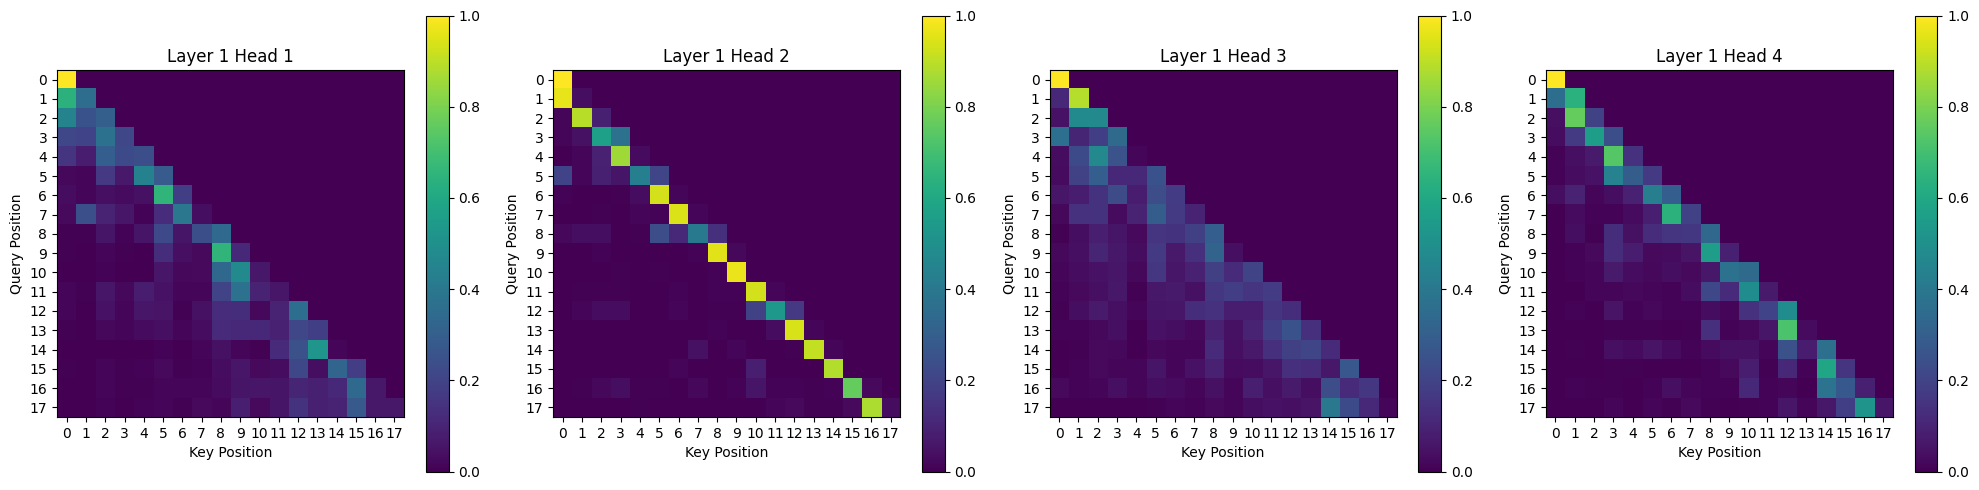

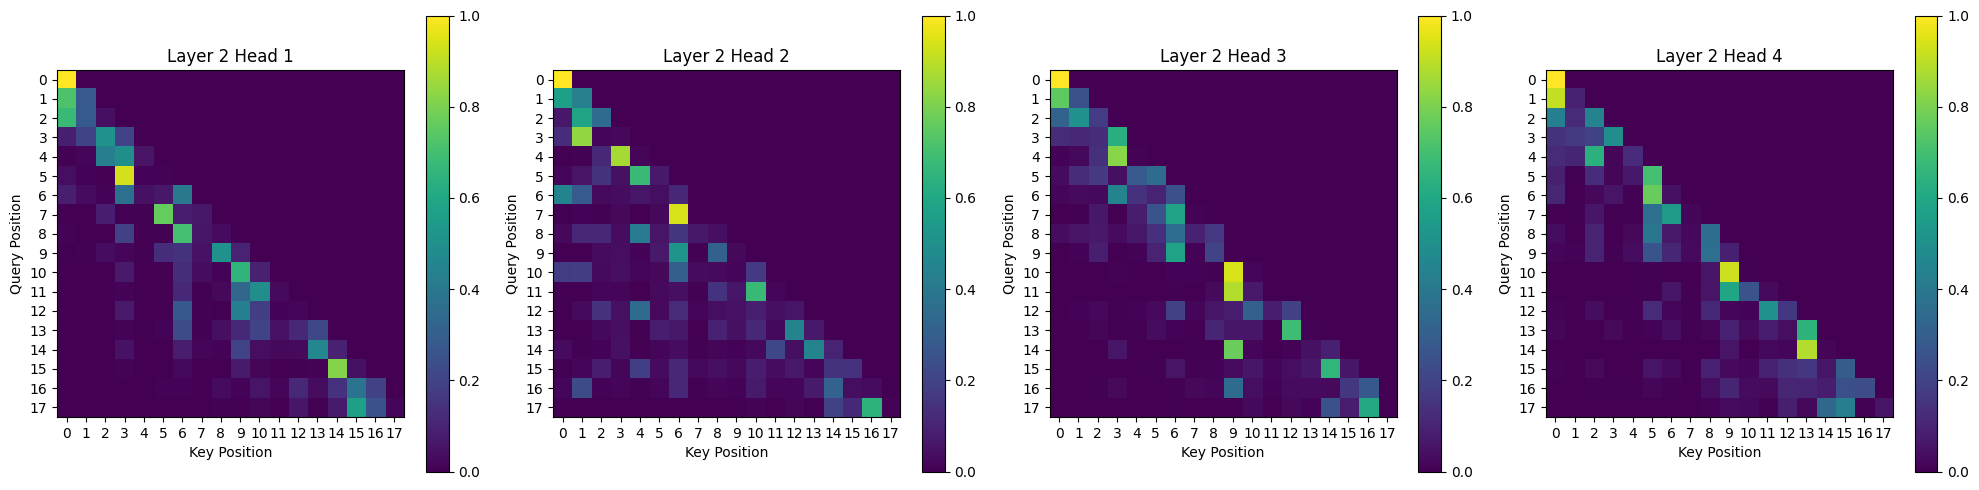

In [34]:
prompt = "To be or not to be"
visualize_attention(model, prompt)

In [36]:
result = generateV2("To be", max_new_tokens=100,use_cache=False)
result

"To bedods.\n'Be Thatizithe,-\nWronder metiry heavily!\nYy,\nMAs wircitle,'I dadole:\nHesst stoown ofoor:-welll"

#### More Epochs!

In [37]:
optimizer = AdamW(model_moe.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=100, gamma=0.9)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 10

In [38]:
# Instancia del Trainer
trainer = Trainer(
    model=model_moe,
    train_data_loader=train_loader,
    test_data_loader=val_loader,
    loss_fn=loss_fn,
    gradient_accumulation_steps=1,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    save_dir="./checkpoints",
    save_every_n=500
)
# Entrenamiento
for epoch in range(epochs):
    avg_train_loss = trainer.train_model_v2(use_amp=True, dtype=torch.bfloat16)
    print(f"Época {epoch+1} - pérdida de entrenamiento: {avg_train_loss:.4f}")

    val_loss = trainer.eval_model()
    print(f"Época {epoch+1} - pérdida de validación: {val_loss:.4f}")

print("Entrenamiento completo.")

  0%|          | 0/11246 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
loss 1.88481: 100%|██████████| 11246/11246 [03:07<00:00, 59.92it/s]


Época 1 - pérdida de entrenamiento: 1.9120


val_loss 1.67298: 100%|██████████| 1246/1246 [00:09<00:00, 126.42it/s]


Época 1 - pérdida de validación: 1.7854


loss 1.79424: 100%|██████████| 11246/11246 [03:06<00:00, 60.20it/s]


Época 2 - pérdida de entrenamiento: 1.8081


val_loss 1.67298: 100%|██████████| 1246/1246 [00:09<00:00, 130.12it/s]


Época 2 - pérdida de validación: 1.7854


loss 1.80295: 100%|██████████| 11246/11246 [03:10<00:00, 58.98it/s]


Época 3 - pérdida de entrenamiento: 1.7751


val_loss 1.67298: 100%|██████████| 1246/1246 [00:10<00:00, 122.21it/s]


Época 3 - pérdida de validación: 1.7854


loss 1.82182: 100%|██████████| 11246/11246 [03:07<00:00, 59.97it/s]


Época 4 - pérdida de entrenamiento: 1.8220


val_loss 1.67298: 100%|██████████| 1246/1246 [00:09<00:00, 128.11it/s]


Época 4 - pérdida de validación: 1.7854


loss 1.84703: 100%|██████████| 11246/11246 [03:07<00:00, 60.14it/s]


Época 5 - pérdida de entrenamiento: 1.8898


val_loss 1.67298: 100%|██████████| 1246/1246 [00:09<00:00, 127.62it/s]


Época 5 - pérdida de validación: 1.7854


loss 1.84390: 100%|██████████| 11246/11246 [03:07<00:00, 59.92it/s]


Época 6 - pérdida de entrenamiento: 1.8393


val_loss 1.67298: 100%|██████████| 1246/1246 [00:09<00:00, 128.66it/s]


Época 6 - pérdida de validación: 1.7854


loss 1.86125: 100%|██████████| 11246/11246 [03:07<00:00, 59.87it/s]


Época 7 - pérdida de entrenamiento: 1.8354


val_loss 1.67298: 100%|██████████| 1246/1246 [00:09<00:00, 127.20it/s]


Época 7 - pérdida de validación: 1.7854


loss 1.85286: 100%|██████████| 11246/11246 [03:08<00:00, 59.62it/s]


Época 8 - pérdida de entrenamiento: 1.8346


val_loss 1.67298: 100%|██████████| 1246/1246 [00:09<00:00, 128.35it/s]


Época 8 - pérdida de validación: 1.7854


loss 1.81918: 100%|██████████| 11246/11246 [03:08<00:00, 59.59it/s]


Época 9 - pérdida de entrenamiento: 1.8655


val_loss 1.67298: 100%|██████████| 1246/1246 [00:10<00:00, 122.56it/s]


Época 9 - pérdida de validación: 1.7854


loss 1.82451: 100%|██████████| 11246/11246 [03:07<00:00, 59.99it/s]


Época 10 - pérdida de entrenamiento: 1.7457


val_loss 1.67298: 100%|██████████| 1246/1246 [00:09<00:00, 127.72it/s]

Época 10 - pérdida de validación: 1.7854
Entrenamiento completo.


In [39]:
result = generateV2("To be", max_new_tokens=100,use_cache=False)
result

"To beniumboor sadsery;;\nWeell.ns,.\nBy'er,\nWronkoulssear:-shy, wheir on'd\nHhtrow turerte\nhungolss\nAut hund"

In [40]:
config

GPTConfig(block_size=32, batch_size=8, n_embd=64, n_head=4, n_layer=2, dropout=0.1, vocab_size=61, bias=True, ff_class=<class '__main__.MoEFFN'>, moe=MoEArgs(num_experts=4, num_experts_per_token=1))

### Conclusiones

1. El modelo quedó demasiado chico para producir buena calidad: pocas capas y un tokenizer por caracteres hacen que no llegue a capturar patrones útiles, incluso con MoE.

2. El MoE no aporta casi nada en este tamaño; los expertos reciben muy poca señal y la “capacidad extra” pareciera que no se llega a usar de una manera util.

3. El mayor limitante termina siendo el propio setup (char-level + arquitectura mínima). Para que el MoE marque una diferencia, el modelo base tendría que ser un poco más grande + mas datos.


# ¡Felicitaciones! 🎉

Después de completar las tareas has preentrenado satisfactoriamente para fi... ¡Ahora puedes presumir ante tus amigos sobre cómo funcionan los LLM y los GPT!